# Setup
- Make sure you have created a virtual environment
- activate the environment and run the requirements.txt with pip: `pip install -r requirements.txt`
- From the environment, start this jupyter notebook: `jupyter notebook`

In [3]:
from dotenv import load_dotenv
load_dotenv() #OPENAI_API_KEY

True

# Build a simple graph

In [4]:
# All imports
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

## Define the state

In [5]:
from typing_extensions import TypedDict

class State(TypedDict):
  graph_state: str

## Build the nodes

In [6]:
def node_1(state):
  print("### Node 1 ###")
  return {"graph_state": state['graph_state'] +" Heads you win. Tails I win: "}

def node_2(state):
  print("### Node 2 ###")
  return {"graph_state": state['graph_state'] +" head!"}

def node_3(state):
  print("### Node 3 ###")
  return {"graph_state": state['graph_state'] +" tail!"}

## Build the edges

In [7]:
import random
from typing import Literal
# This is naive 50/50 intellgence.
# This can be your LLM doing a clever AI task
def coin_toss(state) -> Literal["node_2", "node_3"]:
  user_input = state['graph_state']

  if random.random() < 0.5:
    return "node_2"
  else:
    return "node_3"

## Build and compile the graph

In [8]:
# Add graph nodes
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)
# Add graph edges
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", coin_toss)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)
# compile graph
simple_graph = builder.compile()

## Visualize the graph

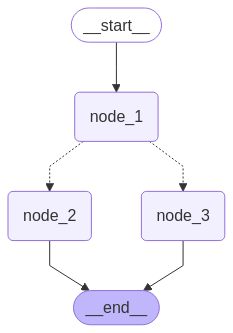

In [10]:
display(Image(simple_graph.get_graph().draw_mermaid_png()))

## Run the graph

In [25]:
simple_graph.invoke({"graph_state" : "Let's toss a coin."})

### Node 1 ###
### Node 2 ###


{'graph_state': "Let's toss a coin. Heads you win. Tails I win:  head!"}

# Graph with LLM Model + Tool calling => ReAct Agent!

In [10]:
# All imports
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

## Define the tools

In [11]:
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def multiply(a: int, b: int) -> int:
    """Multiplies a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]

## Define LLM and power it with tools

In [13]:
# Define LLM with bound tools
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

In [12]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic operations on a given set of inputs.")

# Node with LLM assistant
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

## Build the graph

In [14]:

builder = StateGraph(MessagesState)

# Our assistant and Tools nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

# compile the graph
react_graph = builder.compile()

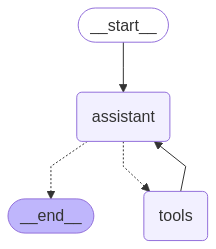

In [15]:
# visualize the graph
display(Image(react_graph.get_graph().draw_mermaid_png()))

## Run the graph

In [18]:
messages = [HumanMessage(content="Add 7 and 3. Multiply the output by 2. Divide the output by 5")]
messages = react_graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 7 and 3. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (call_tHCiOVF9MNho7uROgWInoVb5)
 Call ID: call_tHCiOVF9MNho7uROgWInoVb5
  Args:
    a: 7
    b: 3
================================= Tool Message =================================
Name: add

10
================================== Ai Message ==================================
Tool Calls:
  multiply (call_PkwMGhN4xpOHiwuXQRVWi77v)
 Call ID: call_PkwMGhN4xpOHiwuXQRVWi77v
  Args:
    a: 10
    b: 2
================================= Tool Message =================================
Name: multiply

20
================================== Ai Message ==================================
Tool Calls:
  divide (call_6VpbPwI3UQnxrWkDxscd6Y89)
 Call ID: call_6VpbPwI3UQnxrWkDxscd6Y89
  Args:
    a: 20
    b: 5
================================= Tool Message =============